# Inductive Conformal Prediction

In [43]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import PredictionError


In [44]:
df = pd.read_csv("../data/clean/data.csv")

In [45]:
df.shape

(1000, 29)

In [46]:
NUM_FEATURES = ["md_ft", "proppant_volume", "total_number_of_stages", "azimuth", "isip", "porosity", "proppant_fluid_ratio", "pump_rate", "tvd_ft"]
CAT_FEATURES = ["treatment_company", "operator"]

In [47]:
X = df[NUM_FEATURES + CAT_FEATURES]
y = df["production"]

In [48]:
# split the datasets into 3 datasets: proper traininig set, calibration and test
# proper training set is used to train the underlying model, calibration set is used by Conformal Prediction
# test set is used to test models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, shuffle = True, random_state=42)

# we will use 1000 objects for calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=300)

In [49]:
print('Data split. Parts sizes: train = {}, calib = {}, test = {}'.format(X_proper_train.shape, X_cal.shape, X_test.shape))

Data split. Parts sizes: train = (650, 11), calib = (300, 11), test = (50, 11)


In [50]:
# Define the preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=20))  # One-hot encode categorical features
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUM_FEATURES),
        ('cat', categorical_transformer, CAT_FEATURES)
    ])

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, criterion="absolute_error", max_depth=20, max_features="sqrt", max_samples=None, random_state=42, n_jobs=-1))
])

In [51]:
pipeline.fit(X_proper_train, y_proper_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['md_ft', 'proppant_volume',
                                                   'total_number_of_stages',
                                                   'azimuth', 'isip',
                                                   'porosity',
                                                   'proppant_fluid_ratio',
                                                   'pump_rate', 'tvd_ft']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=20))]),
                                                  ['treatment_company',
                                                   'operator'])])),
                ('regressor',
                 RandomForestRegressor(criterion='absolute_error', max_depth=20,
                                       max_features='sqrt', n_estimators=200,
                                       n_jobs=-1, random_state=42))])

In [52]:
alpha = 0.10
n_cal = len(y_cal)
print(n_cal)

300


In [53]:
# make point predictions on the calibration and test sets
y_pred_cal = pipeline.predict(X_cal)
y_pred_test = pipeline.predict(X_test)

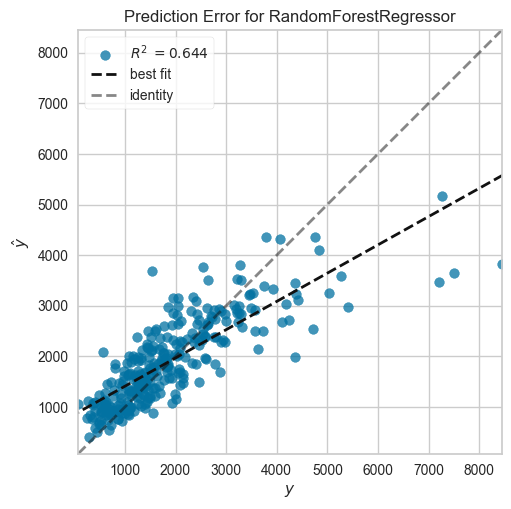

In [54]:
visualizer = PredictionError(pipeline)
visualizer.score(X_cal, y_cal)  # Evaluate the model on the test data
visualizer.show()
plt.show()

In [55]:
# calculate calibraion errors
y_cal_error = np.abs(y_cal - y_pred_cal)

In [56]:
# calculate quantile with final sample adjustment to ensure coverage
np.ceil((n_cal+1)*(1-alpha))/n_cal

0.9033333333333333

In [57]:
#calculate q_hat on the calibration set
q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)
q_yhat_cal

964.1574154783871

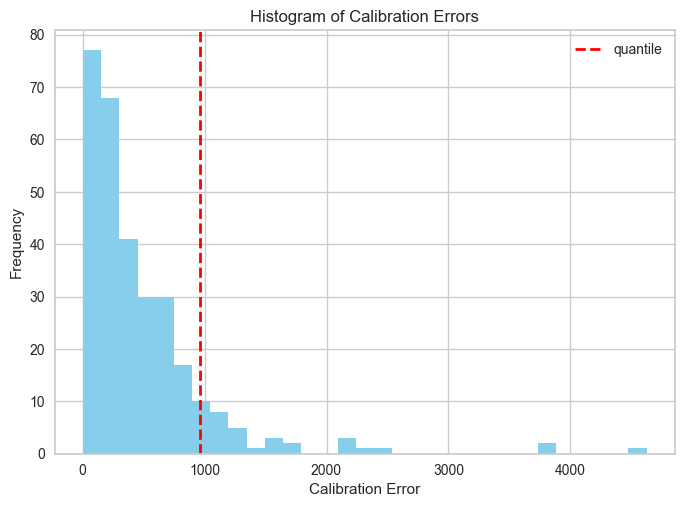

In [58]:
# Plot the histogram
plt.hist(y_cal_error, bins='auto', color='skyblue')

# Add a vertical line for the
plt.axvline(q_yhat_cal, color='red', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Calibration Error')
plt.ylabel('Frequency')
plt.title('Histogram of Calibration Errors')
plt.show()

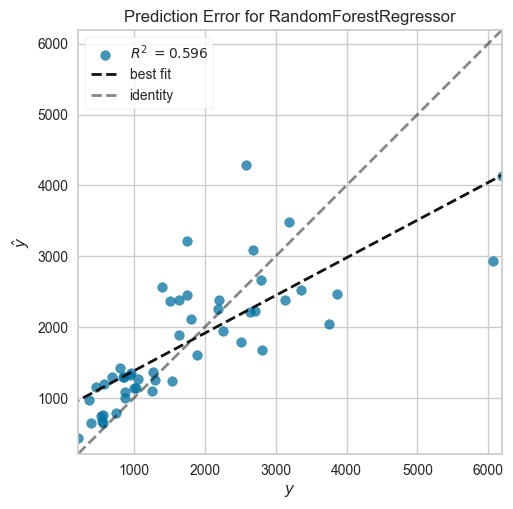

In [59]:
visualizer = PredictionError(pipeline)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()
plt.show()

In [60]:
y_hat_test_lower = y_pred_test - q_yhat_cal
y_hat_test_upper = y_pred_test + q_yhat_cal

In [61]:
predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])
predict_df

,actual,predicted,lower_bound,upper_bound
0,953.718404,1352.411218,388.253802,2316.568633
1,1296.963172,1247.169129,283.011713,2211.326544
2,2262.298508,1949.910723,985.753308,2914.068139
3,3183.919430,3479.916530,2515.759114,4444.073945
4,2186.598908,2251.808254,1287.650838,3215.965669
5,1894.104453,1611.501863,647.344448,2575.659279
6,942.131505,1322.123944,357.966528,2286.281359
7,866.147196,1089.254696,125.097281,2053.412112
8,6189.762211,4138.106485,3173.949070,5102.263901
9,3133.792915,2384.408637,1420.251221,3348.566052


In [62]:
def calculate_coverage(df):
    df['in_interval'] = df.apply(lambda row: row['lower_bound'] <= row['actual'] <= row['upper_bound'], axis=1)
    coverage = df['in_interval'].mean()
    return coverage

coverage = calculate_coverage(predict_df)
print(f"Coverage: {coverage}")

Coverage: 0.84


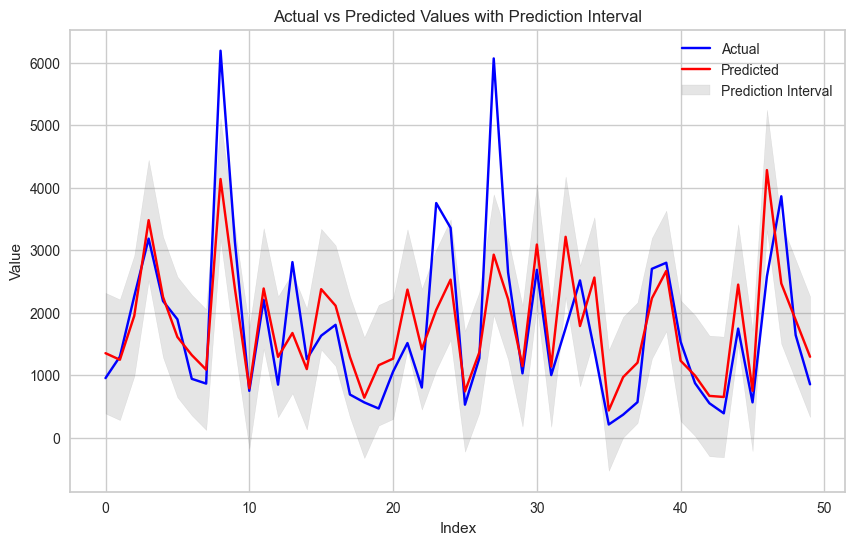

In [63]:
# Sort DataFrame by 'actual' values for smooth line plots

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(predict_df['actual'], label='Actual', color='blue')

# Plot predicted values
plt.plot(predict_df['predicted'], label='Predicted', color='red')

# Plot prediction intervals
plt.fill_between(predict_df.index, predict_df['lower_bound'], predict_df['upper_bound'],
                 color='gray', alpha=0.2, label='Prediction Interval')

# Add the legend
plt.legend()

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Prediction Interval')

# Show the plot
plt.show()
